# 1x2 MMI Splitter Design with Optimizable Tapers (Generated by Script)

This notebook designs a 1x2 Multimode Interference (MMI) splitter with taper sections optimized using Luminescent AI.

In [3]:
import os
os.environ['PATH'] += ':/home/oslab/Luminescent/bin'

## 2. MMI and Simulation Parameters

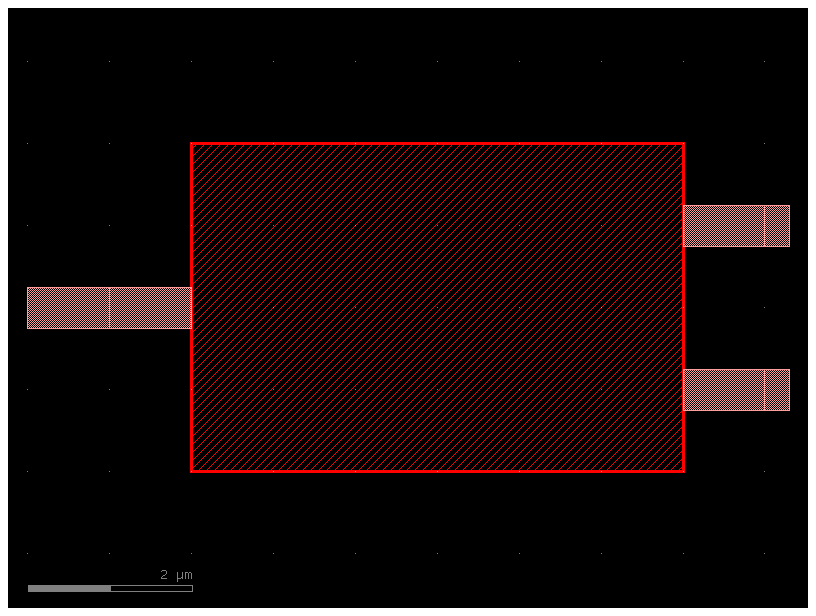

In [4]:
import os
import luminescent as lumi
from luminescent import DESIGN, WG, CLAD
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack

path = os.path.join("runs", "mmi_splitter")
length = 6.0  # 增加长度（MMI 需要更长的多模区域）
width = 4.0   # 增加宽度（容纳多模干涉）
width_wg = 0.5

# margins
source_port_margin = 1
port_margin = 0.3
xmargin_mode = 0.5

# 创建组件
c = gf.Component()

# 使用 lumi.mimo 定义 MMI 结构（移除 io 参数）
dut = c << lumi.mimo(
    length,
    width,
    west=1,   # 输入端口（1 个）
    east=2,   # 输出端口（2 个）
    width_wg=width_wg,
    layer=WG,
    design_layer=DESIGN,
)

# 添加扩展波导（输入和输出）
ext_input = c << gf.components.straight(source_port_margin, width=width_wg)
ext_output1 = c << gf.components.straight(port_margin, width=width_wg)
ext_output2 = c << gf.components.straight(port_margin, width=width_wg)

# 连接端口
ext_input.connect("o2", dut.ports["o1"])      # 输入
ext_output1.connect("o1", dut.ports["o2"])    # 输出 1
ext_output2.connect("o1", dut.ports["o3"])    # 输出 2

# 添加所有端口到组件
c.add_port("o1", port=dut.ports["o1"])
c.add_port("o2", port=dut.ports["o2"])
c.add_port("o3", port=dut.ports["o3"])

# 添加 CLAD 层边界
c << gf.components.bbox(component=c, layer=CLAD, top=1, bottom=1)
c.plot()
c.show()


xmargin_mode: [0.5, 0.5]
using simulation folder runs/mmi_splitter
loading problem from /home/oslab/Luminescent.jl/runs/mmi_splitter

running Luminescent julia backend
λ = F(center_wavelength) = 1.55f0
setting up simulation...
meshing geometry - can take few minutes...
12.090569 seconds (10.25 M allocations: 630.527 MiB, 16.96% gc time, 79.99% compilation time)
making sources...
solving modal profile...
2d
making monitors...
solving modal profile...
2d
solving modal profile...
2d
solving modal profile...
2d
making designs...
----------------------------------------

simulation setup complete

backend: CPU
float: Float32

original size: (126, 68)
padded size: (157, 84)
cell count: 13,188

step size: 22.0 steps/period
max time: 30.00 periods
time steps: 660

computation load: 8,704,080 cell-steps

compiling simulation code...
starting optimization... first iter will be slow due to adjoint compilation.

[1]
241.181520 seconds (77.50 M allocations: 14.436 GiB, 8.00% gc time, 28.57% compila

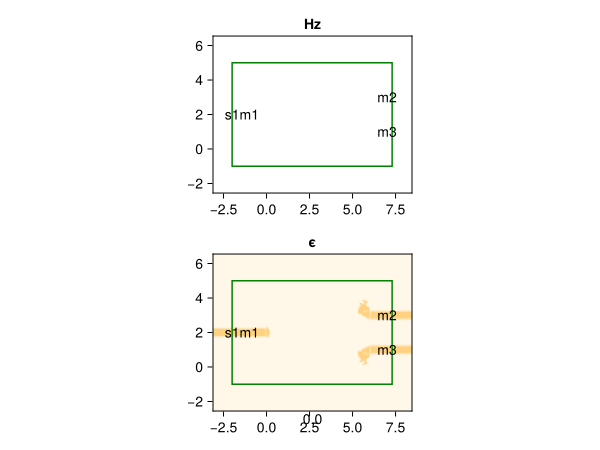

In [5]:
import os
import luminescent as lumi
from luminescent import DESIGN, WG, CLAD
import gdsfactory as gf
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack

# ========== 关键参数调整 ==========
path = os.path.join("runs", "mmi_splitter_v2")  # 新路径避免冲突
length = 4.0      # 调整长度（经验公式：MMI长度 ≈ 3π/(4β0 - β1)）
width = 3.0       # 调整宽度（宽度需支持多模干涉）
width_wg = 0.45   # 波导宽度微调（与波长匹配）

# 边界设置
source_port_margin = 2.0  # 输入端口延长（确保模式稳定）
port_margin = 0.5        # 输出端口延长
xmargin_mode = 0.6        # 仿真区域扩展

# ========== 组件定义 ==========
c = gf.Component()
dut = c << lumi.mimo(
    length,
    width,
    west=1,   # 输入端口
    east=2,   # 输出端口
    width_wg=width_wg,
    layer=WG,
    design_layer=DESIGN,
    # 新增参数（若版本支持）
    taper_length=0.5,  # 输入输出锥形波导（可选）
)

# 添加扩展波导
ext_input = c << gf.components.straight(source_port_margin, width=width_wg)
ext_output1 = c << gf.components.straight(port_margin, width=width_wg)
ext_output2 = c << gf.components.straight(port_margin, width=width_wg)

# 连接端口
ext_input.connect("o2", dut.ports["o1"])
ext_output1.connect("o1", dut.ports["o2"])
ext_output2.connect("o1", dut.ports["o3"])

# 添加端口和CLAD层
for port in ["o1", "o2", "o3"]:
    c.add_port(port, port=dut.ports[port])
c << gf.components.bbox(component=c, layer=CLAD, top=1, bottom=1)

# ========== 优化目标强化 ==========
targets = [
    # 主目标：均分光功率（放宽容差）
    lumi.Target("o2@0,o1@0", 0.48, weight=0.4, wavelength=1.55)]+[  # 目标48% ±5%
    lumi.Target("o3@0,o1@0", 0.48, weight=0.4, wavelength=1.55)]+[
    # 辅助目标：抑制反射和串扰
    lumi.Target("o1@0,o1@0", 0.0, weight=0.1, wavelength=1.55)]+[  # 反射<5%
    lumi.Target("o2@0,o3@0", 0.0, weight=0.1, wavelength=1.55)   # 串扰<5%
]

# ========== 优化器参数调整 ==========
lumi.make_prob(
    path,
    c,
    targets=targets,
    symmetries=["y"],          # 强制对称性
    materials=lumi.MATERIALS,
    layer_stack=lumi.SOI220,
    approx_2D_mode="TE",
    lmin=0.12,                 # 更小特征尺寸（提升设计自由度）
    fill_material="Si",
    void_material="SiO2",
    source_port_margin=source_port_margin,
    xmargin_mode=xmargin_mode,
    relcourant=0.9,            # 更稳定的Courant条件
    nres=7,                    # 更高网格分辨率
    T=40,                      # 更长时间窗口
    init_holes=False,          # 关闭初始孔洞（避免局部最优）
    stoploss=0.01,             # 更严格的收敛条件
    iters=150,                 # 更多迭代次数
    saveat=10,
    force=True,
)

# 运行优化
lumi.solve(path)
lumi.make_movie(path)

## 4. LayerStack and Materials

## 5. Optimization Targets

## 6. Configure and Create Simulation Problem (lumi.make_prob)

## 7. Run Optimization and Create Movie

## 8. Load and Plot Results (Illustrative)